In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from iminuit import Minuit

import emcee
from pprint import pprint
import time
from multiprocessing import Pool

import random

## 2002 统计分析

In [2]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_02(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata02 = pd.read_csv("perlist02_s.csv")
    f = perdata02['f']
    per = perdata02['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata02)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [3]:
m02=Minuit(twi_minus_loglikelihood_02,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_poisson=0.02,
         limit_log_A=(-3,-1), limit_log_f_b=(-7,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,5),
         errordef=1)

m02.migrad()

pprint(m02.fval)

FCN = 3216.7603982110963 
 TOTAL NCALL = 662 
 NCALLS = 662 
 
 
 EDM = 9.701765890078746e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.58626,0.173628,,,-3,-1,No
1,log_f_b,-3.64086,0.21966,,,-7,-2,No
2,alpha_H,2.64402,0.456955,,,1,5,No
3,poisson,2.56949,0.126888,,,0,5,No


3216.7603982110963


In [4]:
perdata02 = pd.read_csv("perlist02_s.csv")
f_02 = perdata02['f']
per_02 = perdata02['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m02.values[0],m02.values[1],m02.values[2],m02.values[3]

model_02 = []
R_obs_02 = []
T_SSE_obs_02 = 0
f_length_02 = len(f_02)
for i in range(f_length_02):
    model_02.append(((f_02[i]**(-alpha_L))/(1+(f_02[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_02.append(2*per_02[i]/model_02[i])
    T_SSE_obs_02 += (((per_02[i]-model_02[i])/model_02[i])**2)

# 两个统计量
T_R_obs_02 = max(R_obs_02)
print ("T_R =", T_R_obs_02)
print ("T_SSE =", T_SSE_obs_02)

T_R = 28.060151823448074
T_SSE = 770.9075956189315


In [5]:
# 5000条光变曲线

df = 0.01/f_length_02
N = 2*f_length_02
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_02]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_02):
        R_simu.append(2*per_simu[i]/model_02[i])
        T_SSE_simu += (((per_simu[i]-model_02[i])/model_02[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_02:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_02:
        n_TSSE += 1

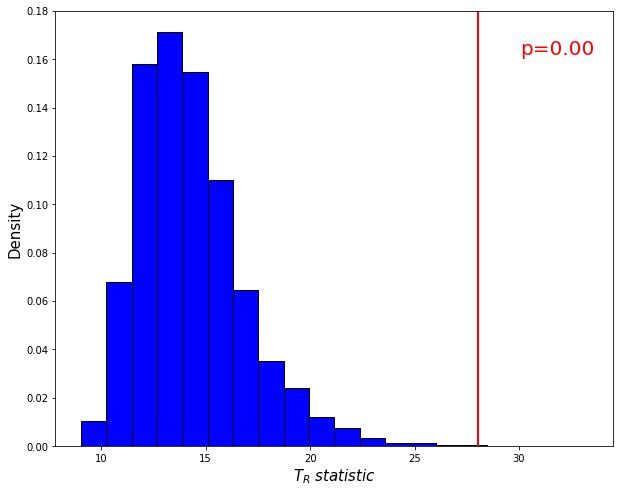

In [6]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_02, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

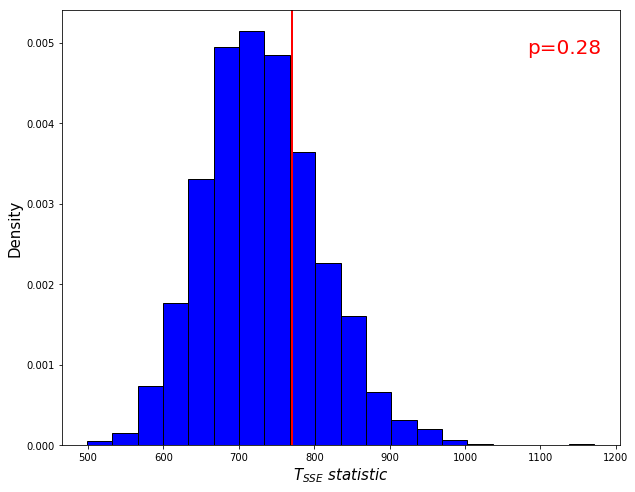

In [7]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_02, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2008(1) 统计分析

In [8]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_081(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata081 = pd.read_csv("perlist081_s.csv")
    f = perdata081['f']
    per = perdata081['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata081)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [9]:
m081=Minuit(twi_minus_loglikelihood_081,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_poisson=0.02,
         limit_log_A=(-3,-1), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

m081.migrad()

pprint(m081.fval)

FCN = 3065.902296526707 
 TOTAL NCALL = 476 
 NCALLS = 476 
 
 
 EDM = 3.907039520803827e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.46353,0.160744,,,-3,-1,No
1,log_f_b,-3.59187,0.212729,,,-5,-2,No
2,alpha_H,2.55233,0.323355,,,1,5,No
3,poisson,1.68621,0.0853704,,,0,2,No


3065.902296526707


In [10]:
perdata081 = pd.read_csv("perlist081_s.csv")
f_081 = perdata081['f']
per_081 = perdata081['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m081.values[0],m081.values[1],m081.values[2],m081.values[3]

model_081 = []
R_obs_081 = []
T_SSE_obs_081 = 0
f_length_081 = len(f_081)
for i in range(f_length_081):
    model_081.append(((f_081[i]**(-alpha_L))/(1+(f_081[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_081.append(2*per_081[i]/model_081[i])
    T_SSE_obs_081 += (((per_081[i]-model_081[i])/model_081[i])**2)

# 两个统计量
T_R_obs_081 = max(R_obs_081)
print ("T_R =", T_R_obs_081)
print ("T_SSE =", T_SSE_obs_081)

T_R = 12.250466502681435
T_SSE = 785.6330658803171


In [11]:
# 5000条光变曲线

df = 0.01/f_length_081
N = 2*f_length_081
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_081]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_081):
        R_simu.append(2*per_simu[i]/model_081[i])
        T_SSE_simu += (((per_simu[i]-model_081[i])/model_081[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_081:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_081:
        n_TSSE += 1

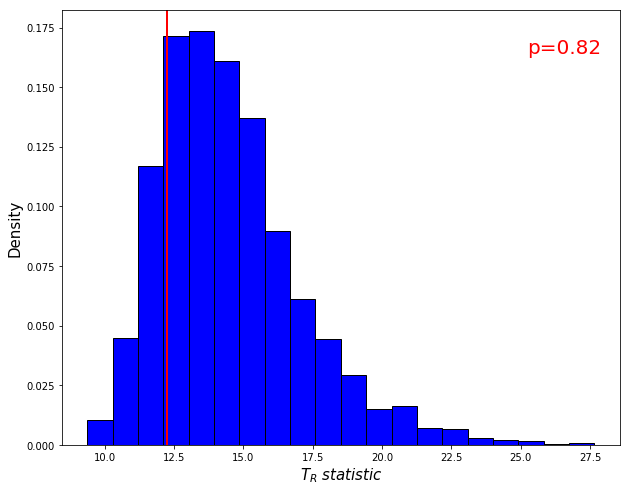

In [12]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_081, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

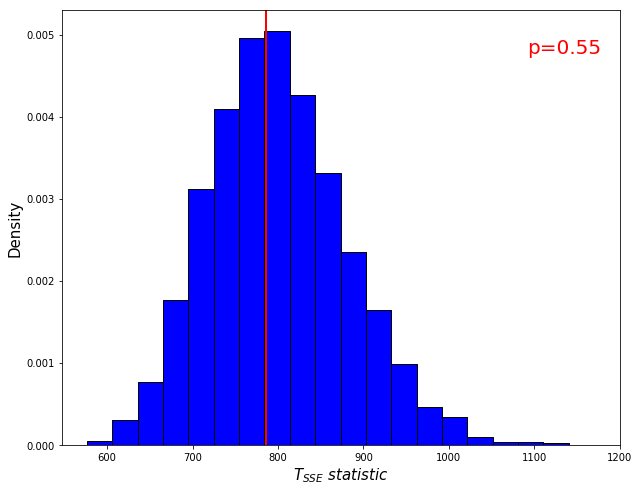

In [13]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_081, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2010(1) 统计分析

In [14]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_101(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata101 = pd.read_csv("perlist101_s.csv")
    f = perdata101['f']
    per = perdata101['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata101)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [15]:
m101=Minuit(twi_minus_loglikelihood_101,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_poisson=0.02,
         limit_log_A=(-3,0), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,5),
         errordef=1)

m101.migrad()

pprint(m101.fval)

FCN = 4343.459605043079 
 TOTAL NCALL = 403 
 NCALLS = 403 
 
 
 EDM = 2.211684335196783e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.06905,0.194881,,,-3,0,No
1,log_f_b,-3.92706,0.220362,,,-5,-2,No
2,alpha_H,2.59771,0.284829,,,1,5,No
3,poisson,2.34628,0.10422,,,0,5,No


4343.459605043079


In [16]:
perdata101 = pd.read_csv("perlist101_s.csv")
f_101 = perdata101['f']
per_101 = perdata101['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m101.values[0],m101.values[1],m101.values[2],m101.values[3]

model_101 = []
R_obs_101 = []
T_SSE_obs_101 = 0
f_length_101 = len(f_101)
for i in range(f_length_101):
    model_101.append(((f_101[i]**(-alpha_L))/(1+(f_101[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_101.append(2*per_101[i]/model_101[i])
    T_SSE_obs_101 += (((per_101[i]-model_101[i])/model_101[i])**2)
    
# 两个统计量
T_R_obs_101 = max(R_obs_101)
print ("T_R =", T_R_obs_101)
print ("T_SSE =", T_SSE_obs_101)

T_R = 20.836971777470392
T_SSE = 1095.3410029829347


In [17]:
# 5000条光变曲线

df = 0.01/f_length_101
N = 2*f_length_101
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_101]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_101):
        R_simu.append(2*per_simu[i]/model_101[i])
        T_SSE_simu += (((per_simu[i]-model_101[i])/model_101[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_101:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_101:
        n_TSSE += 1

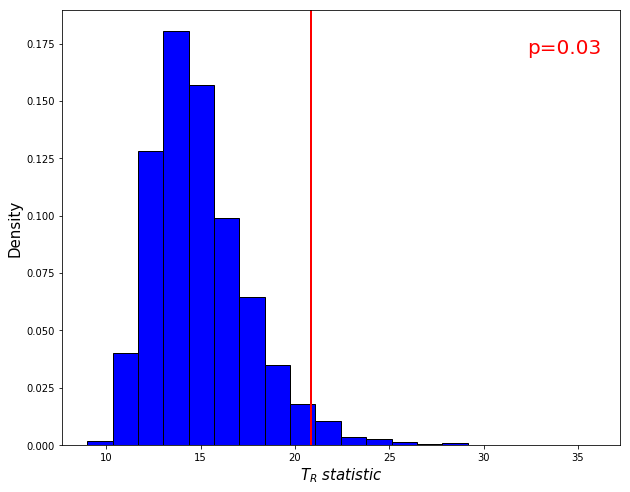

In [18]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_101, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

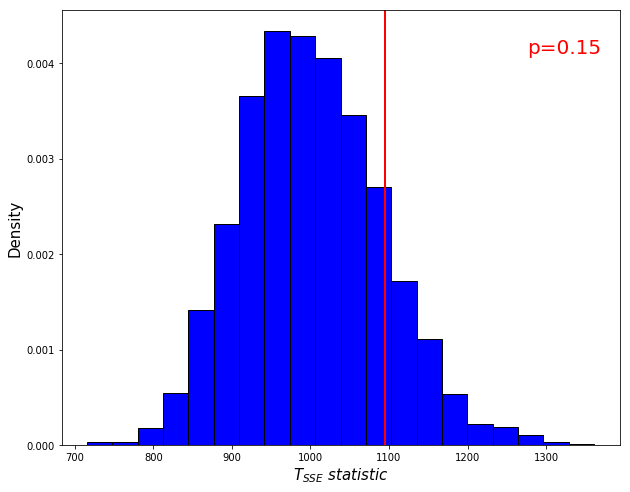

In [19]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_101, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2007(4) 统计分析

In [20]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_074(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata074 = pd.read_csv("perlist074_s.csv")
    f = perdata074['f']
    per = perdata074['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata074)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [21]:
m074=Minuit(twi_minus_loglikelihood_074,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_poisson=0.02,
         limit_log_A=(-3,0), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,5),
         errordef=1)

m074.migrad()

pprint(m074.fval)

FCN = 1621.961946994236 
 TOTAL NCALL = 422 
 NCALLS = 422 
 
 
 EDM = 7.162486925862816e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.49036,0.178178,,,-3,0,No
1,log_f_b,-3.43935,0.188222,,,-5,-2,No
2,alpha_H,3.14835,0.586692,,,1,5,No
3,poisson,1.89139,0.114571,,,0,5,No


1621.961946994236


In [22]:
perdata074 = pd.read_csv("perlist074_s.csv")
f_074 = perdata074['f']
per_074 = perdata074['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m074.values[0],m074.values[1],m074.values[2],m074.values[3]

model_074 = []
R_obs_074 = []
T_SSE_obs_074 = 0
f_length_074 = len(f_074)
for i in range(f_length_074):
    model_074.append(((f_074[i]**(-alpha_L))/(1+(f_074[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_074.append(2*per_074[i]/model_074[i])
    T_SSE_obs_074 += (((per_074[i]-model_074[i])/model_074[i])**2)
    
# 两个统计量
T_R_obs_074 = max(R_obs_074)
print ("T_R =", T_R_obs_074)
print ("T_SSE =", T_SSE_obs_074)

T_R = 11.167480378300278
T_SSE = 390.39009123645275


In [23]:
# 5000条光变曲线

df = 0.01/f_length_074
N = 2*f_length_074
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_074]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_074):
        R_simu.append(2*per_simu[i]/model_074[i])
        T_SSE_simu += (((per_simu[i]-model_074[i])/model_074[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_074:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_074:
        n_TSSE += 1

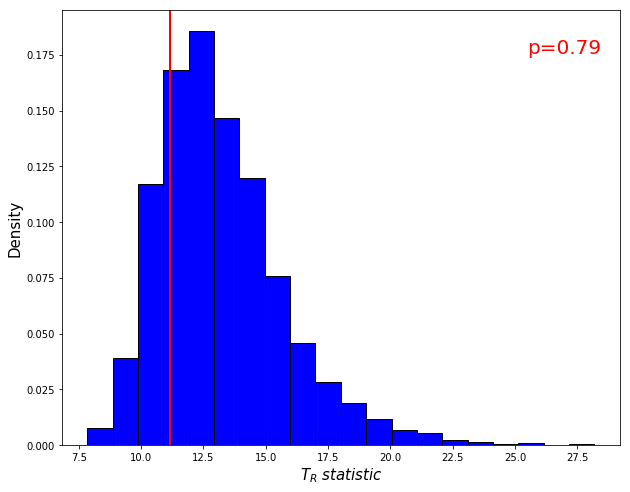

In [24]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_074, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

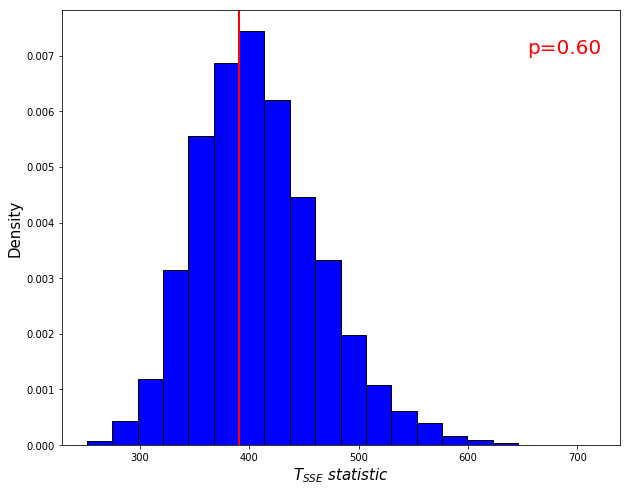

In [25]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_074, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2007(2) 统计分析

In [26]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_072(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata072 = pd.read_csv("perlist072_s.csv")
    f = perdata072['f']
    per = perdata072['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata072)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [27]:
m072=Minuit(twi_minus_loglikelihood_072,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_poisson=0.02,
         limit_log_A=(-3,0), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,5),
         errordef=1)

m072.migrad()

pprint(m072.fval)

FCN = 2069.105674013275 
 TOTAL NCALL = 356 
 NCALLS = 356 
 
 
 EDM = 0.00012576937282074825 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-0.881308,0.275159,,,-3,0,No
1,log_f_b,-3.74952,0.298095,,,-5,-2,No
2,alpha_H,2.9133,0.575214,,,1,5,No
3,poisson,3.86625,0.248707,,,0,5,No


2069.105674013275


In [28]:
perdata072 = pd.read_csv("perlist072_s.csv")
f_072 = perdata072['f']
per_072 = perdata072['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m072.values[0],m072.values[1],m072.values[2],m072.values[3]

model_072 = []
R_obs_072 = []
T_SSE_obs_072 = 0
f_length_072 = len(f_072)
for i in range(f_length_072):
    model_072.append(((f_072[i]**(-alpha_L))/(1+(f_072[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_072.append(2*per_072[i]/model_072[i])
    T_SSE_obs_072 += (((per_072[i]-model_072[i])/model_072[i])**2)
    
# 两个统计量
T_R_obs_072 = max(R_obs_072)
print ("T_R =", T_R_obs_072)
print ("T_SSE =", T_SSE_obs_072)

T_R = 10.032434457399415
T_SSE = 349.3923030837456


In [29]:
# 5000条光变曲线

df = 0.01/f_length_072
N = 2*f_length_072
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_072]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_072):
        R_simu.append(2*per_simu[i]/model_072[i])
        T_SSE_simu += (((per_simu[i]-model_072[i])/model_072[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_072:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_072:
        n_TSSE += 1

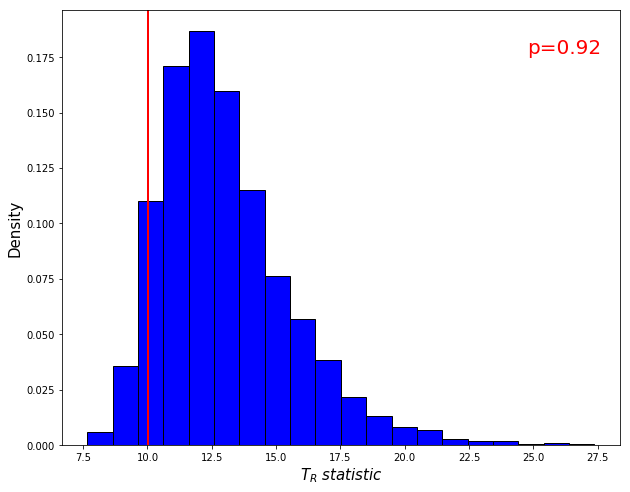

In [30]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_072, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

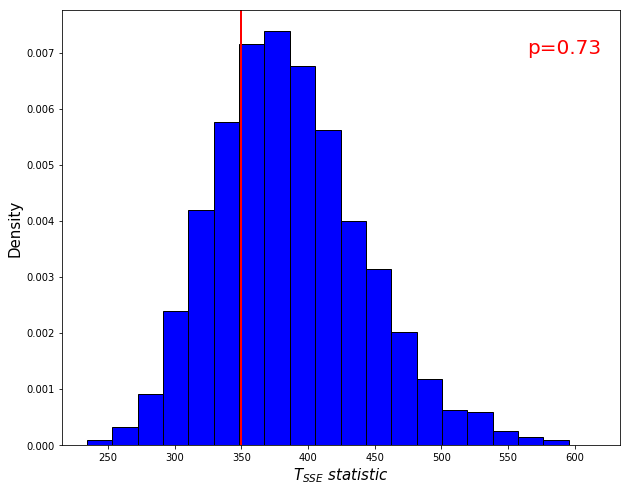

In [31]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_072, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 综合结果

In [17]:
data02 = pd.read_csv("energy_1h0707_02.csv")  
x02 = data02['x']
y02 = data02['y']
xerr02 = data02['xerr']
yerr02 = data02['yerr']

data081 = pd.read_csv("energy_1h0707_081.csv")  
x081 = data081['x']
y081 = data081['y']
xerr081 = data081['xerr']
yerr081 = data081['yerr']

data101 = pd.read_csv("energy_1h0707_101.csv")  
x101 = data101['x']
y101 = data101['y']
xerr101 = data101['xerr']
yerr101 = data101['yerr']

data074 = pd.read_csv("energy_1h0707_074.csv")  
x074 = data074['x']
y074 = data074['y']
xerr074 = data074['xerr']
yerr074 = data074['yerr']

data072 = pd.read_csv("energy_1h0707_072.csv")  
x072 = data072['x']
y072 = data072['y']
xerr072 = data072['xerr']
yerr072 = data072['yerr']

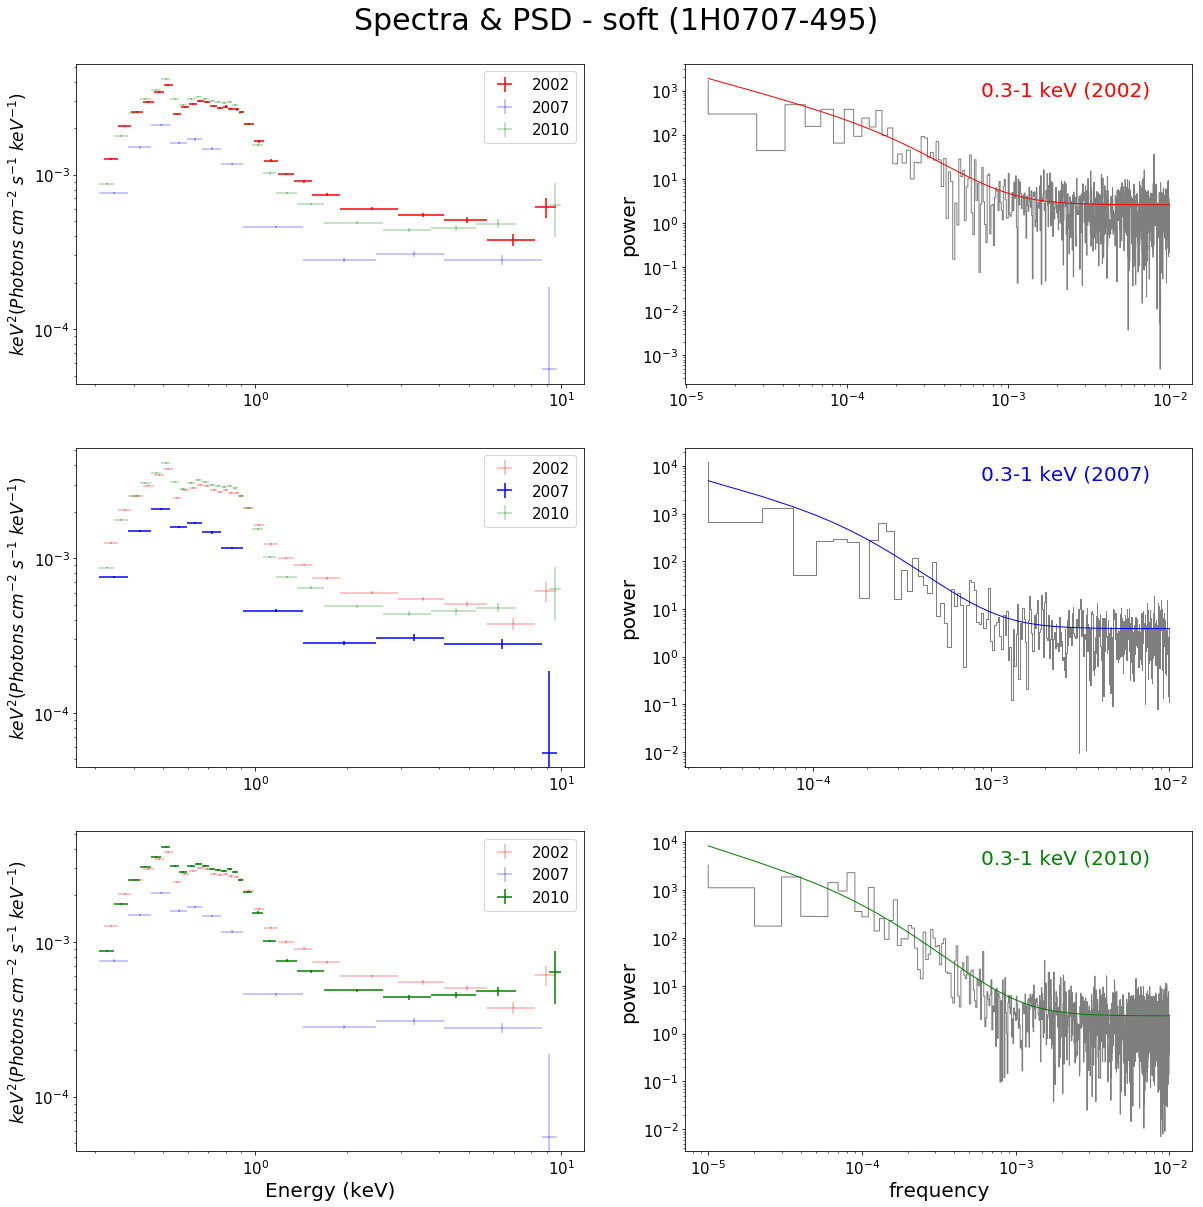

In [19]:
fig= plt.figure(figsize=(20,20))
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)



ax1.loglog()
ax1.errorbar(x02, y02, yerr=yerr02, xerr=xerr02, fmt=',r', label='2002')
#ax1.errorbar(x081, y081, yerr=yerr081, xerr=xerr081, fmt=',b', alpha=0.3, label='2008')
ax1.errorbar(x072, y072, yerr=yerr072, xerr=xerr072, fmt=',b', alpha=0.3, label='2007')
ax1.errorbar(x101, y101, yerr=yerr101, xerr=xerr101, fmt=',g', alpha=0.3, label='2010')
#ax1.set_xlabel("Energy (keV)",fontsize=20)
ax1.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)

ax3.loglog()
ax3.errorbar(x02, y02, yerr=yerr02, xerr=xerr02, fmt=',r', alpha=0.3, label='2002')
#ax3.errorbar(x081, y081, yerr=yerr081, xerr=xerr081, fmt=',b', label='2008')
ax3.errorbar(x072, y072, yerr=yerr072, xerr=xerr072, fmt=',b', label='2007')
ax3.errorbar(x101, y101, yerr=yerr101, xerr=xerr101, fmt=',g', alpha=0.3, label='2010')
#ax3.set_xlabel("Energy (keV)",fontsize=20)
ax3.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax3.legend(fontsize=15)
ax3.tick_params(labelsize=15)

ax5.loglog()
ax5.errorbar(x02, y02, yerr=yerr02, xerr=xerr02, fmt=',r', alpha=0.3, label='2002')
#ax5.errorbar(x081, y081, yerr=yerr081, xerr=xerr081, fmt=',b', alpha=0.3, label='2008')
ax5.errorbar(x072, y072, yerr=yerr072, xerr=xerr072, fmt=',b', alpha=0.3, label='2007')
ax5.errorbar(x101, y101, yerr=yerr101, xerr=xerr101, fmt=',g', label='2010')
ax5.set_xlabel("Energy (keV)",fontsize=20)
ax5.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax5.legend(fontsize=15)
ax5.tick_params(labelsize=15)



ax2.loglog()
ax2.step(f_02, per_02, color="k", alpha=0.5, linewidth=1)
ax2.plot(f_02, model_02, color="r", linewidth=1)
#ax2.set_xlabel("frequency",fontsize=20)
ax2.set_ylabel("power",fontsize=20)
ax2.text(0.75,0.9,"0.3-1 keV (2002)",color='r',ha='center',transform=ax2.transAxes,fontsize=20)
ax2.tick_params(labelsize=15)

ax4.loglog()
ax4.step(f_072, per_072, color="k", alpha=0.5, linewidth=1)
ax4.plot(f_072, model_072, color="b", linewidth=1)
#ax4.set_xlabel("frequency",fontsize=20)
ax4.set_ylabel("power",fontsize=20)
ax4.text(0.75,-0.3,"0.3-1 keV (2007)",color='b',ha='center',transform=ax2.transAxes,fontsize=20)
ax4.tick_params(labelsize=15)

ax6.loglog()
ax6.step(f_101, per_101, color="k", alpha=0.5, linewidth=1)
ax6.plot(f_101, model_101, color="g", linewidth=1)
ax6.set_xlabel("frequency",fontsize=20)
ax6.set_ylabel("power",fontsize=20)
ax6.text(0.75,-1.5,"0.3-1 keV (2010)",color='g',ha='center',transform=ax2.transAxes,fontsize=20)
ax6.tick_params(labelsize=15)



plt.suptitle("Spectra & PSD - soft (1H0707-495)", x=0.5, y=0.92, fontsize=30)
plt.show()

## 2002 MCMC

In [34]:
# 均匀先验

def lnprior_02(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -3 < log_A < 0 and -5 < log_f_b < -2 and 1.0 < alpha_H < 5.0 and 0.0 < poisson < 5.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_02(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_02(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_02(log_A,log_f_b,alpha_H,poisson))

In [35]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m02.values[0],m02.values[1],m02.values[2],m02.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_02)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 968.4 seconds


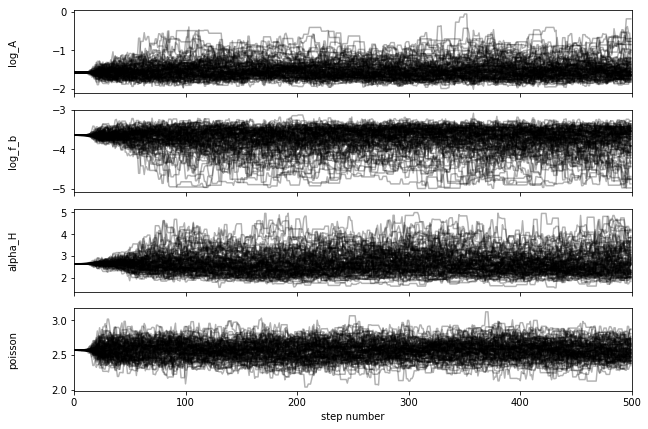

In [36]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [37]:
print ("Parameters (2002)")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2002)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

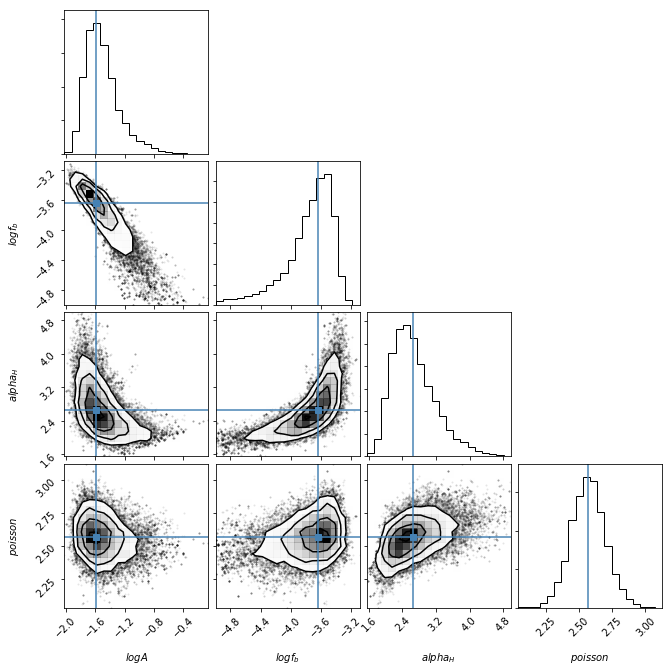

In [38]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m02.values[0], m02.values[1], m02.values[2], m02.values[3]])

## 2007(2) MCMC

In [54]:
# 均匀先验

def lnprior_072(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -5 < log_A < 3 and -10 < log_f_b < 0 and 1.0 < alpha_H < 10.0 and 0.0 < poisson < 5.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_072(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_072(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_072(log_A,log_f_b,alpha_H,poisson))

In [55]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m072.values[0],m072.values[1],m072.values[2],m072.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_072)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 631.7 seconds


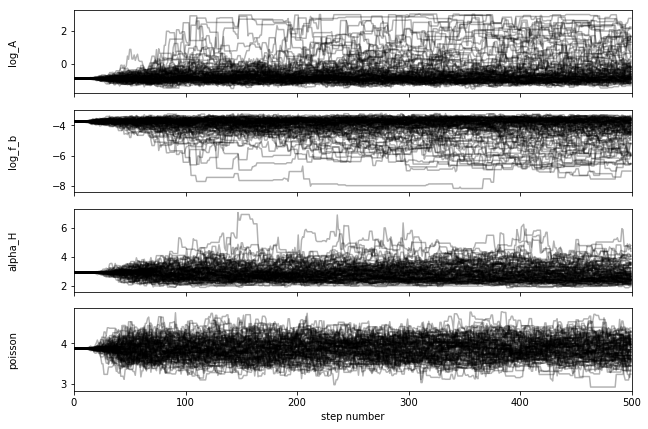

In [56]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [57]:
print ("Parameters (2007)")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2007)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

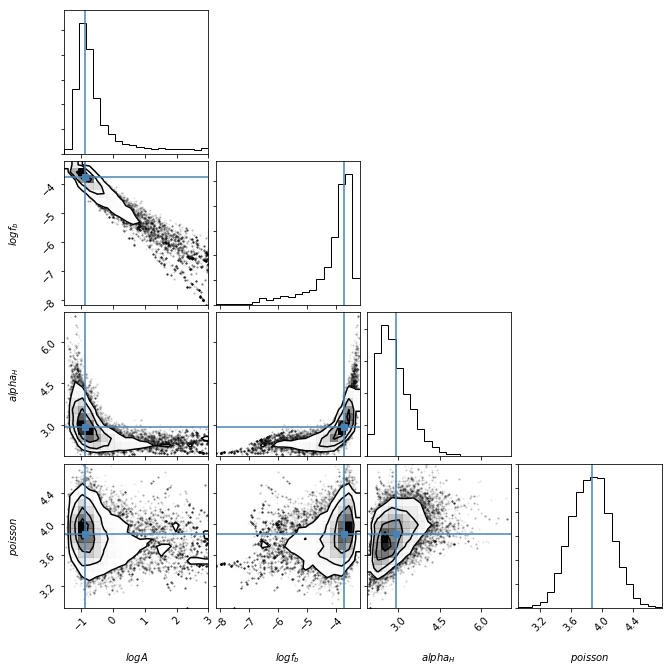

In [58]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m072.values[0], m072.values[1], m072.values[2], m072.values[3]])

## 2010(1) MCMC

In [29]:
# 均匀先验

def lnprior_101(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -3 < log_A < 0 and -5 < log_f_b < 0 and 1.0 < alpha_H < 5.0 and 0.0 < poisson < 5.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_101(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_101(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_101(log_A,log_f_b,alpha_H,poisson))

In [30]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m101.values[0],m101.values[1],m101.values[2],m101.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_101)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 1295.2 seconds


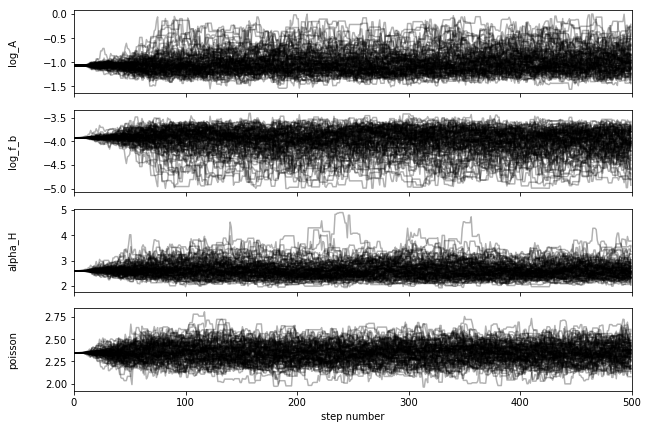

In [31]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [32]:
print ("Parameters (2010)")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2010)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

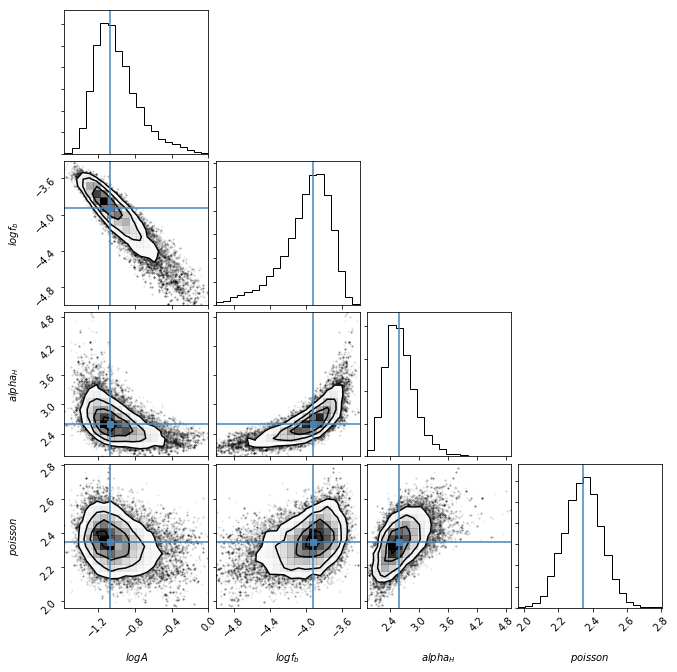

In [33]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m101.values[0], m101.values[1], m101.values[2], m101.values[3]])